[回帰：燃費を予測する  \|  TensorFlow Core](https://www.tensorflow.org/tutorials/keras/regression?hl=ja)

In [1]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.1.0


### Auto MPG データセットのダウンロード

1. mpg(燃費)：連続
2. cylinders(シリンダー)：多値離散
3. displacement(変位)：連続
4. horsepower(馬力)：連続
5. weight(重量)：連続
6. acceleration(加速)：連続
7. model year(モデル年)：多値離散
8. origin(起源)：多値離散
9. car name(車名)：文字列（各インスタンスに固有）

In [2]:
#dataset_path = keras.utils.get_file("auto-mpg.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path = '../input/auto-mpg/auto-mpg.data'

In [3]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin'] 
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                          na_values = "?", comment='\t',
                          sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


### データのクレンジング

欠損値があるかどうかは .isna() で調べることができる。

欠損値を含む行は .dropna() で削除することができる。

In [4]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [5]:
dataset = dataset.dropna()

"Origin"の列を数値からカテゴリーに変更する （one-hot encoding）

In [6]:
origin = dataset.pop('Origin') # Origin列だけを抽出して、datasetから削除する
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


### データを訓練用セットとテスト用セットに分割

In [7]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### データの観察

訓練用セットのいくつかの列の組み合わせの同時分布を見てみる

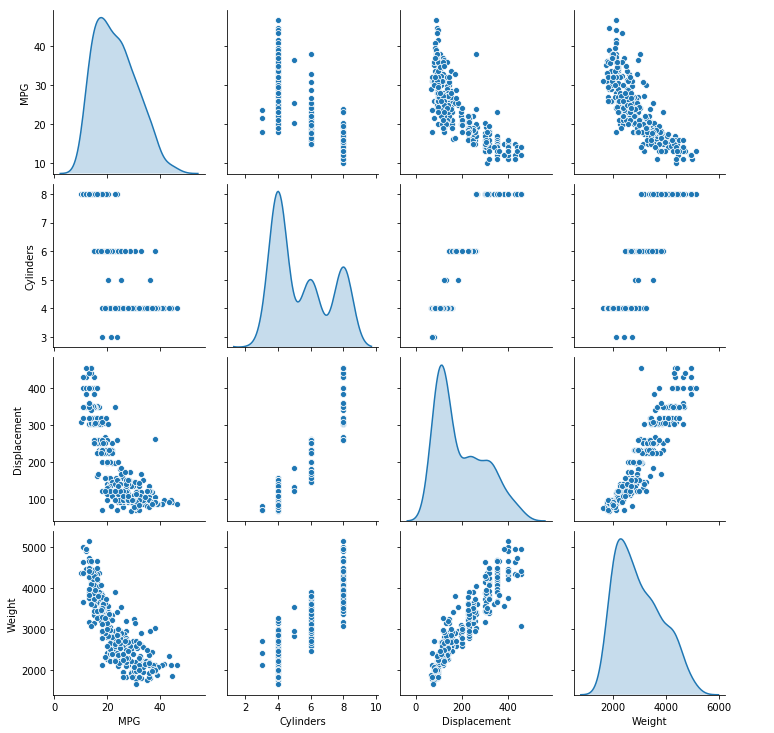

In [8]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

全体の統計値を表示する。 `.transpose()` するのは後で正規化するときに平均(mean)と標準偏差(std)を使うため。

In [9]:
train_stats = train_dataset.describe()
train_stats.pop("MPG") # 目的変数の統計値は表示しない
train_stats = train_stats.transpose()
train_stats # 説明変数の統計値を表示する

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


### ラベルと特徴量の分離

MPG(燃費)は目的変数なので、特徴量から切り離す。

In [10]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

### データの正規化

特徴量の正規化なしでもモデルは収束するかもしれないが、モデルの訓練はより難しくなり、結果として得られたモデルも入力で使われる単位に依存することになる。

標準化は以下のように各データ $x_i$ から平均 $\mu$ を引き、その値を標準偏差 $\sigma$ で割る

$$z_i = \frac{x_i - \mu}{\sigma}$$

In [11]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [12]:
normed_train_data

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
146,-0.869348,-1.009459,-0.784052,-1.025303,-0.379759,-0.516397,0.774676,-0.465148,-0.495225
282,-0.869348,-0.530218,-0.442811,-0.118796,0.624102,0.843910,0.774676,-0.465148,-0.495225
69,1.483887,1.482595,1.447140,1.736877,-0.738281,-1.060519,0.774676,-0.465148,-0.495225
378,-0.869348,-0.865687,-1.099044,-1.025303,-0.308055,1.660094,0.774676,-0.465148,-0.495225
331,-0.869348,-0.942365,-0.994047,-1.001603,0.875068,1.115971,-1.286751,-0.465148,2.012852
...,...,...,...,...,...,...,...,...,...
281,0.307270,0.044872,-0.521559,-0.000298,0.946772,0.843910,0.774676,-0.465148,-0.495225
229,1.483887,1.961837,1.972127,1.457223,-1.598734,0.299787,0.774676,-0.465148,-0.495225
150,-0.869348,-0.836932,-0.311564,-0.710099,-0.021237,-0.516397,-1.286751,-0.465148,2.012852
145,-0.869348,-1.076553,-1.151543,-1.169870,1.233589,-0.516397,-1.286751,-0.465148,2.012852


### モデルの構築

- 指標
  - mae : Mean Abs Error (平均絶対誤差) 
    $$\mathrm{MAE} = \frac{1}{N}\sum_{i=1}^{N} \left| y_i - \hat{y_i} \right|$$
  - mse : Mean Square Error (平均二乗誤差)
    $$\mathrm{MSE} = \frac{1}{N}\sum_{i=1}^{N} ( y_i - \hat{y_i} )^2$$

In [13]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [14]:
model = build_model()

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


### モデルの動作確認

訓練用データのうち10個のサンプルからなるバッチを取り出し、それを使ってmodel.predictメソッドを呼び出す

In [15]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[0.3754926 ],
       [0.3083929 ],
       [0.9329039 ],
       [0.44386494],
       [0.49250296],
       [0.20954475],
       [0.45105037],
       [0.64887905],
       [0.30915463],
       [0.36444122]], dtype=float32)

期待どおりの型と期待通りの形の出力が得られている

### モデルの訓練

モデルを1000エポック訓練し、訓練と検証の正解率をhistoryオブジェクトに記録する

In [16]:
# エポックが終わるごとにドットを一つ出力することで進捗を表示
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split=0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

historyオブジェクトに保存された数値を使ってモデルの訓練の様子を可視化する

In [17]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.922884,1.112818,2.922885,8.910988,2.242483,8.910989,995
996,2.779803,1.092791,2.779803,8.886961,2.241989,8.886961,996
997,2.923023,1.129148,2.923023,8.802639,2.266619,8.802639,997
998,2.857001,1.104733,2.857001,8.984573,2.260487,8.984573,998
999,3.111577,1.131833,3.111577,8.978490,2.274419,8.978490,999


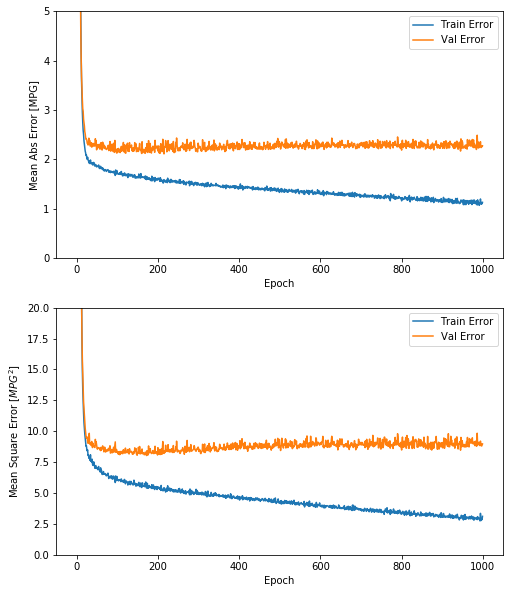

In [18]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure(figsize=(8,10))
  plt.subplot(2, 1, 1)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()
  
  plt.subplot(2, 1, 2)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)


グラフを見ると、検証エラーは100エポックを過ぎたあたりで改善が見られなくなり、むしろ悪化しているようです。検証スコアの改善が見られなくなったら自動的に訓練を停止するように、model.fitメソッド呼び出しを変更します。ここでは、エポック毎に訓練状態をチェックするEarlyStoppingコールバックを使用します。設定したエポック数の間に改善が見られない場合、訓練を自動的に停止します。


...................................................

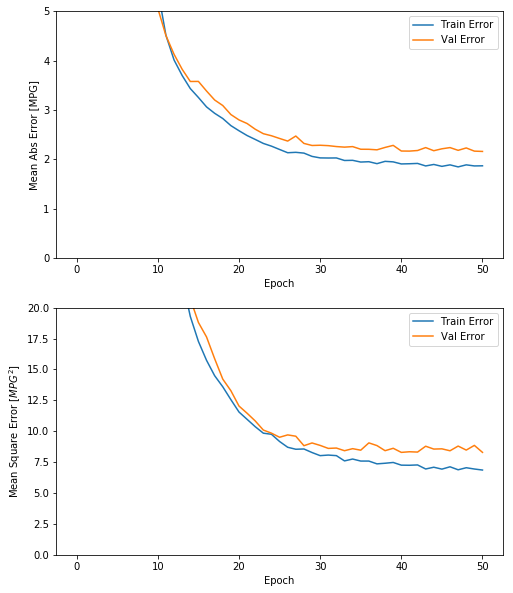

In [19]:
model = build_model()

# patience は改善が見られるかを監視するエポック数を表すパラメーター
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

検証用データセットでのグラフを見ると、平均誤差は +/- 2 MPG（マイル/ガロン）前後

### テスト用データでモデルの評価

In [20]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

78/78 - 0s - loss: 5.7824 - mae: 1.8939 - mse: 5.7824
Testing set Mean Abs Error:  1.89 MPG


### モデルを使った予測

テストデータを使ってMPGを予測する

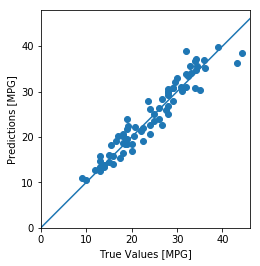

In [21]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

グラフからは、そこそこよい予測ができている。次は誤差の分布。

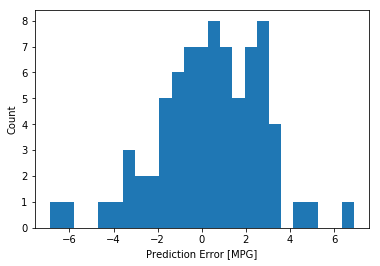

In [22]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel("Prediction Error [MPG]")
plt.ylabel("Count")
plt.show()

とても正規分布には見えないが、サンプル数が非常に小さいからだと考えられる

### 結論

回帰問題を扱うためのテクニック

- 回帰問題の一般的な「損失関数」は平均二乗誤差（MSE: Mean Squared Error）
- 回帰問題の一般的な「評価指標」は平均絶対誤差（MAE: Mean Absolute Error）
- 入力数値特徴量の範囲が異なっている場合、特徴量ごとにおなじ範囲に正規化すべき
- 訓練用データが多くない場合、過学習を避けるために少ない隠れ層をもつ小さいネットワークを使うのがよい
- Early Stoppingは過学習を防止するための便利な手法の一つ